In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

In [12]:
batch_size = 64

In [69]:
train_loader = DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)
test_loader = DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=5, shuffle=False)

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [15]:
model = Net()
optimizer = Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [17]:
epochs = 1
for epoch in range(epochs):
    losses = 0
    i = 0
    for x, y in train_loader:

        y_hat = model(x)

        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses += loss.item()
        i += 1

    print(f'Epoch: {epoch}, loss: {losses / i}')


Epoch: 0, loss: 0.34418514790311294


In [29]:
i = 0
acc = 0

for x_test, y_test in test_loader:

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)

    y_argmax = y_pred.argmax(1)

    acc += len(torch.nonzero(y_argmax == y_test)) / len(y_test)
    i += 1

print(f'accuracy = {acc / i}')

accuracy = 0.9749203821656051


In [30]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [75]:
def test(epsilon=0):

    acc = 0
    i = 0

    for x, y in test_loader:

        x.requires_grad_()

        y_hat = model(x)
        init_pred = y_hat.argmax(1)

        loss = F.nll_loss(y_hat, y)
        model.zero_grad()
        loss.backward()

        perturbed_data = fgsm_attack(x, epsilon, x.grad.data)

        y_hat_fake = model(perturbed_data)
        final_pred = y_hat_fake.argmax(1)

        if i == 0:
            print(f'Epsilon: {epsilon}')

            for i in range(len(x)):
                print(f'{i+1}. Real: {y[i]}, Prediction: {init_pred[i]}, Perturbed: {final_pred[i]}')
                plt.imshow(perturbed_data[i].detach().numpy()[0], cmap='gray')
                plt.show()

        acc += len(torch.nonzero(final_pred == y)) / len(y)
        i += 1

    return acc / i

In [77]:
epsilons = (0.1, 0.3, 0.5, 0.7, 0.9)
accuracies = []

Epsilon: 0.1
1. Real: 7, Prediction: 7, Perturbed: 7
2. Real: 2, Prediction: 2, Perturbed: 2
3. Real: 1, Prediction: 1, Perturbed: 1
4. Real: 0, Prediction: 0, Perturbed: 0
5. Real: 4, Prediction: 4, Perturbed: 4
Epsilon: 0.3
1. Real: 7, Prediction: 7, Perturbed: 7
2. Real: 2, Prediction: 2, Perturbed: 2
3. Real: 1, Prediction: 1, Perturbed: 1
4. Real: 0, Prediction: 0, Perturbed: 0
5. Real: 4, Prediction: 4, Perturbed: 4
Epsilon: 0.5
1. Real: 7, Prediction: 7, Perturbed: 7
2. Real: 2, Prediction: 2, Perturbed: 2
3. Real: 1, Prediction: 1, Perturbed: 1
4. Real: 0, Prediction: 0, Perturbed: 0
5. Real: 4, Prediction: 4, Perturbed: 4
Epsilon: 0.7
1. Real: 7, Prediction: 7, Perturbed: 7
2. Real: 2, Prediction: 2, Perturbed: 2
3. Real: 1, Prediction: 1, Perturbed: 1
4. Real: 0, Prediction: 0, Perturbed: 0
5. Real: 4, Prediction: 4, Perturbed: 9
Epsilon: 0.9
1. Real: 7, Prediction: 7, Perturbed: 7
2. Real: 2, Prediction: 2, Perturbed: 8
3. Real: 1, Prediction: 1, Perturbed: 2
4. Real: 0, Pre

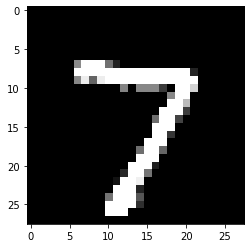

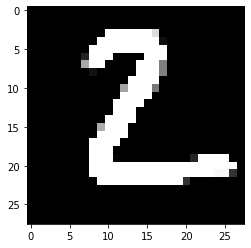

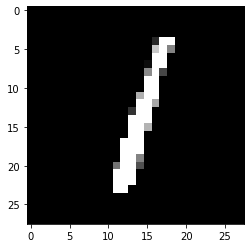

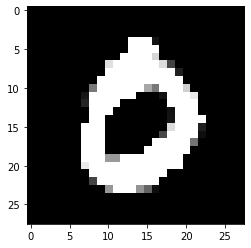

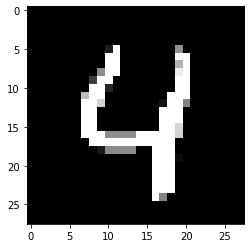

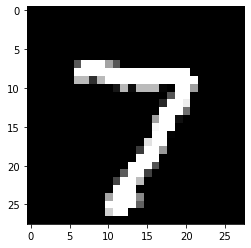

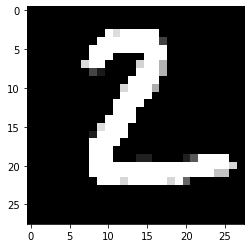

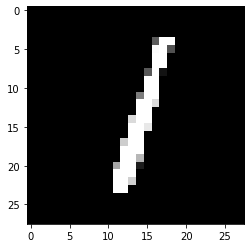

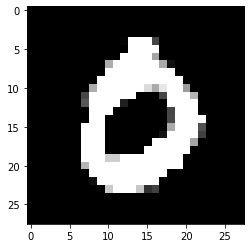

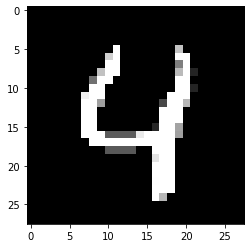

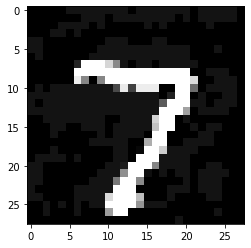

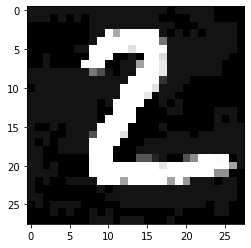

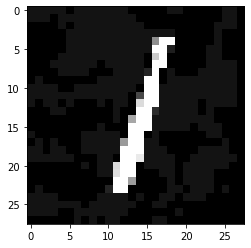

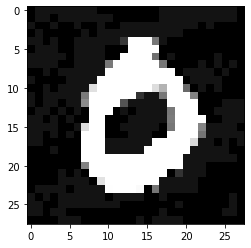

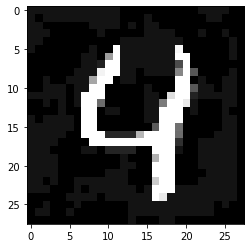

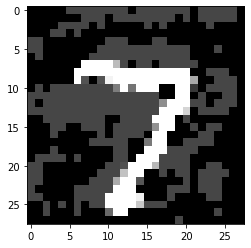

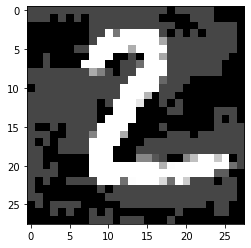

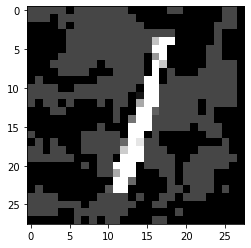

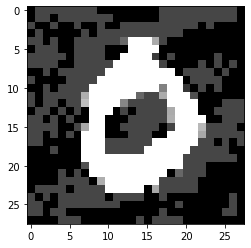

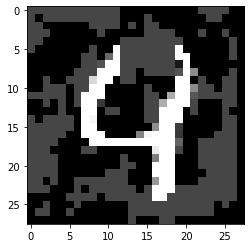

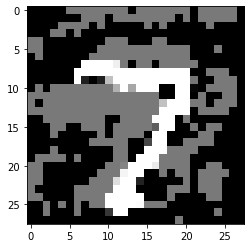

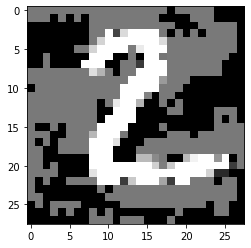

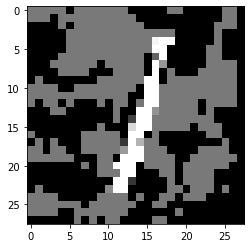

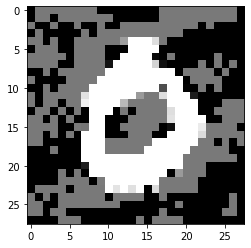

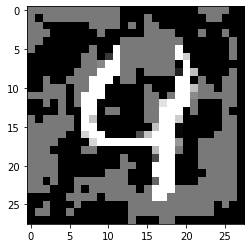

[0.9608782435129697,
 0.9445109780439067,
 0.8500998003991923,
 0.4440119760479033,
 0.14331337325349144]

In [78]:
for e in epsilons:
    accuracies.append(test(e))
accuracies

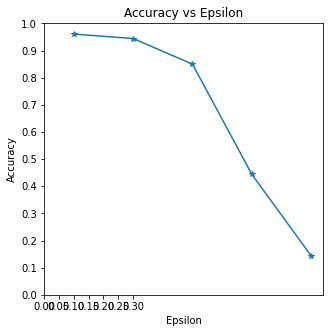

In [80]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()